# Research question: What is the relationship between the SHAP and feature value?


## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). 

In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fited a single model to all of the data (no test set) and focused on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

In this notebook we will use the model from notebook 03a (all data model) and focus on understanding the relationship between the SHAP and feature values for the other 9 features.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). We explore the relationship between SHAP values adn feature values for 9 features (not the hospital feature).

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between the SHAP value and feature values for all features (apart from the hospital feature)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.

### Extra code to check something for the paper

In notebook 03_xgb_combined_shap_key_features.ipynb we used the training set from the first kfold to plot the feature value vs SHAP for the top 6 influencial features.

Here we use the 'all data model', and look at all features to inform the subgroup analysis (to include all features for that too, rather than the selected 3 features)

## Show the relationship between feature value and SHAP value for all the features

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn import linear_model

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03e'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X_data = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X_data.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X_data['Stroke team'], prefix = 'team')
X_data = pd.concat([X_data, X_hosp], axis=1)
X_data.drop('Stroke team', axis=1, inplace=True)

In [11]:
# get feature names
feature_names_ohe = list(X_data)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [12]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X_data)
y_pred_proba = model.predict_proba(X_data)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    print("Run notebook 03a")
    
# Get SHAP values
filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    print("Run notebook 03a")

CPU times: user 449 ms, sys: 1.68 s, total: 2.13 s
Wall time: 248 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

### Read in SHAP interactions from notebook 03b

In [15]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    print("Run notebook 03b_xgb_shap_values_focus_on_ohe_hospitals.ipynb")

CPU times: user 0 ns, sys: 2.84 s, total: 2.84 s
Wall time: 6.94 s


In [16]:
shap_interaction.shape

(88792, 141, 141)

For each patient, remove the SHAP values for the one-hot encoded hosptial features that are not attended (so only have the one-hot encoded hospital attended).

The create five arrays containing a value per feature:
1) SHAP value (sum of row)
2) main effect (diagonal value)
3) SHAP interactions with other features within multiple regression feature set (per feature row, the columns of the other in regression features)
4) SHAP interactions with other features outside multiple regression feature set (per feature row, the columns of the features not in the regression)
5) main effect + SHAP values within: sum array (2) + (3)

### Define the features in each multiple regression

Have two multiple regressions: patient and hosptial

In [17]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

In [18]:
hospital_features = ['Arrival-to-scan time','Stroke team']

Use the data columns to identify ID locations for these features

In [19]:
col_names = list(X_data.columns)
col_names[:10]

['Arrival-to-scan time',
 'Infarction',
 'Stroke severity',
 'Precise onset time',
 'Prior disability level',
 'Use of AF anticoagulants',
 'Onset-to-arrival time',
 'Onset during sleep',
 'Age',
 'team_AGNOF1041H']

In [20]:
hospitals_ohe = X_data.filter(regex='^team',axis=1).columns
hospitals_ohe[:10]

Index(['team_AGNOF1041H', 'team_AKCGO9726K', 'team_AOBTM3098N',
       'team_APXEE8191H', 'team_ATDID5461S', 'team_BBXPQ0212O',
       'team_BICAW1125K', 'team_BQZGT7491V', 'team_BXXZS5063A',
       'team_CNBGF2713O'],
      dtype='object')

Work through 1 patient

In [21]:
p_loc = 0

In [22]:
si = shap_interaction[p_loc]
si.shape

(141, 141)

In [23]:
X_data.columns.shape

(141,)

In [24]:
attend = data["Stroke team"].loc[p_loc]
attend

'TXHRP7672C'

1. Only keep hospital attended column (for each patient, the column to keep and columns to ditch will change)

In [25]:
hospitals_indices = [col_names.index(h) for h in hospitals_ohe]
#hospitals_indices

In [26]:
hospital_keep_index = [col_names.index(f'team_{attend}')]
#hospital_keep_index

In [27]:
# hosptials to remove for this patient (there may be 100 to remove, for the 1 to keep)
hospitals_remove_indices = list(set(hospitals_indices) - set(hospital_keep_index))
#ospitals_remove_indices

Delete the rows and columns for the hospitals not attended

In [28]:
# delete the rows
shap_interaction_attendhosp = np.delete(si, hospitals_remove_indices, 0)
# delete the columns
shap_interaction_attendhosp = np.delete(shap_interaction_attendhosp, hospitals_remove_indices, 1)
shap_interaction_attendhosp.shape

(10, 10)

And remove the not attended hospitals from the column names

In [29]:
col_names_attendhosp = np.delete(col_names, hospitals_remove_indices, 0)

# rename the specific hosptial name with the generic "Stroke team" title
col_names_attendhosp = np.char.replace(col_names_attendhosp, f'team_{attend}', "Stroke team")#new, count=None)
col_names_attendhosp

array(['Arrival-to-scan time', 'Infarction', 'Stroke severity',
       'Precise onset time', 'Prior disability level',
       'Use of AF anticoagulants', 'Onset-to-arrival time',
       'Onset during sleep', 'Age', 'Stroke team'], dtype='<U24')

In [30]:
# number features to get values for
n_si_features = shap_interaction_attendhosp.shape[0]
n_si_features

10

Define the features in each multiple regression, and get their indices

In [31]:
#patient_features_col_id = [col_names_attendhosp.index(f) for f in patient_features]
patient_features_col_id = [np.where(col_names_attendhosp==f)[0][0] for f in patient_features]
patient_features_col_id

[1, 2, 3, 4, 5, 6, 7, 8]

In [32]:
hospital_features_col_id = [np.where(col_names_attendhosp==f)[0][0] for f in hospital_features]
hospital_features_col_id

[0, 9]

#### 1) SHAP values (without any information on hospital attended - main effect and interactions)
The difference between this SHAP value and the SHAP value fro the explainer will be from the excluded values from hospitals not attended

In [33]:
shap_values = shap_interaction_attendhosp.sum(axis=1)
shap_values

array([ 0.7533356 ,  0.48842376,  1.0939053 ,  0.44372398,  0.49860597,
        0.20291501, -0.28451252,  0.03574604,  0.22929987, -0.02271838],
      dtype=float32)

#### 2) main effect value for each of the features ("p_main" and "h_main")

In [34]:
main_effects = np.diagonal(shap_interaction_attendhosp)
main_effects

array([ 0.6762766 ,  0.33838633,  0.86258185,  0.43077266,  0.32212025,
        0.13532187, -0.4415457 ,  0.04296043,  0.23174413, -0.18785165],
      dtype=float32)

#### 3) SHAP interactions within multiple regression feature set ("p_interactions" and "h_interactions")

In [35]:
# put the two lists of features, in a list
list_of_list = [patient_features_col_id,
                hospital_features_col_id]

# initialise a zero array
within_array = np.zeros((n_si_features))

# get a list of features (for patient, and then for hospital)
for features_column_id in list_of_list: 
    # go through each feature
    for i in features_column_id:
        # store the other feature that are in that list
        rest = copy.deepcopy(features_column_id)
        rest.remove(i)

        # initialise a count
        sum_elements = 0
        # for the interactions with the other feautes, sum the values
        for j in rest:
            sum_elements += shap_interaction_attendhosp[i,j]
        # strore in the feature column position
        within_array[i] = sum_elements

print(within_array)

[ 0.          0.10916407  0.09282497  0.04414749  0.09038258  0.0534725
  0.05453578 -0.00730535  0.1063505   0.        ]


#### 4) SHAP interactions outside multiple regression feature set ("interaction_hpph")

In [36]:
outside_array = np.zeros((n_si_features))
for i in patient_features_col_id:
#        print(i)
#        print(mr_features_column_id)
#    rest = patient_mr_features_column_id.remove(i)#np.delete(patient_mr_features_column_id, i, 0)
#        print(rest)
    sum_elements = 0
    for j in hospital_features_col_id:
#            print(j)
        sum_elements += shap_interaction_attendhosp[i,j]
#            print(sum_elements)
    outside_array[i] = sum_elements
    print(outside_array)
#    within_array
#        print(within_array)
for i in hospital_features_col_id:
#        print(i)
#        print(mr_features_column_id)
#    rest = patient_mr_features_column_id.remove(i)#np.delete(patient_mr_features_column_id, i, 0)
#        print(rest)
    sum_elements = 0
    for j in patient_features_col_id:
#            print(j)
        sum_elements += shap_interaction_attendhosp[i,j]
#            print(sum_elements)
    outside_array[i] = sum_elements
    print(outside_array)


[0.         0.04087338 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.         0.04087338 0.13849856 0.         0.         0.
 0.         0.         0.         0.        ]
[ 0.          0.04087338  0.13849856 -0.03119615  0.          0.
  0.          0.          0.          0.        ]
[ 0.          0.04087338  0.13849856 -0.03119615  0.08610316  0.
  0.          0.          0.          0.        ]
[ 0.          0.04087338  0.13849856 -0.03119615  0.08610316  0.01412064
  0.          0.          0.          0.        ]
[ 0.          0.04087338  0.13849856 -0.03119615  0.08610316  0.01412064
  0.1024974   0.          0.          0.        ]
[ 0.00000000e+00  4.08733785e-02  1.38498560e-01 -3.11961472e-02
  8.61031637e-02  1.41206384e-02  1.02497399e-01  9.09566879e-05
  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00  4.08733785e-02  1.38498560e-01 -3.11961472e-02
  8.61031637e-02  1.41206384e-02  1.02497399e-01  9.09566879e-05
 -1.08794756e-01  0.

#### 5) main effect + SHAP interaction within: sum arrays #2 + #3 ("p_main_interactions" and "h_main_interactions")

In [37]:
main_effect_and_within = main_effects + within_array

Values for the patient regression

In [38]:
print(shap_values[patient_features_col_id])
print(main_effects[patient_features_col_id])
print(main_effects[patient_features_col_id] + within_array[patient_features_col_id])
print(outside_array[patient_features_col_id])

[ 0.48842376  1.0939053   0.44372398  0.49860597  0.20291501 -0.28451252
  0.03574604  0.22929987]
[ 0.33838633  0.86258185  0.43077266  0.32212025  0.13532187 -0.4415457
  0.04296043  0.23174413]
[ 0.4475504   0.95540682  0.47492015  0.41250283  0.18879437 -0.38700992
  0.03565508  0.33809462]
[ 4.08733785e-02  1.38498560e-01 -3.11961472e-02  8.61031637e-02
  1.41206384e-02  1.02497399e-01  9.09566879e-05 -1.08794756e-01]


Values for the hosptial regression

In [39]:
print(shap_values[hospital_features_col_id])
print(main_effects[hospital_features_col_id])
print(main_effects[hospital_features_col_id] + within_array[hospital_features_col_id])
print(outside_array[hospital_features_col_id])

[ 0.7533356  -0.02271838]
[ 0.6762766  -0.18785165]
[ 0.67627662 -0.18785165]
[0.07705901 0.16513327]


Package that all up and run for each patient.

Need to store each feature value in a dataframe, then find median value per hosptial for each value type.

In [40]:
%%time

# get indices for the hospitals
hospitals_indices = [col_names.index(h) for h in hospitals_ohe]

# create list (one per value type) with features as column title
shap_values_without_unattended_hosp = []
shap_main_effects = []
shap_interactions_within = []
shap_interactions_outside = []
shap_main_effects_and_within_interactions = []

# work through each patients shap interaction matrix
for p in range(shap_interaction.shape[0]):

    # get shap interactions for a patient
    si = shap_interaction[p]

    # get hospital the patient attends
    attend = data["Stroke team"].loc[p]
    
    # get column index for hosptial attend
    hospital_keep_index = [col_names.index(f'team_{attend}')]

    # get indices for the other hosptials (those not attend) to remove for this patient
    hospitals_remove_indices = list(set(hospitals_indices) - set(hospital_keep_index))
    
    # delete the rows and columns in the shap interaction matrix for the hospitals not attended
    shap_interaction_attendhosp = np.delete(si, hospitals_remove_indices, 0)
    shap_interaction_attendhosp = np.delete(shap_interaction_attendhosp, hospitals_remove_indices, 1)

    # and remove the not attended hospitals from the column names
    col_names_attendhosp = np.delete(col_names, hospitals_remove_indices, 0)

    # rename the one hosptial left with the generic "Stroke team" name
    col_names_attendhosp = np.char.replace(col_names_attendhosp, f'team_{attend}', "Stroke team")#new, count=None)
    
    # number of features in the resulting shap interaction matrix
    n_si_features = shap_interaction_attendhosp.shape[0]

    # get the indices for the features in each multiple regression
    patient_features_col_id = [np.where(col_names_attendhosp==f)[0][0] for f in patient_features]
    hospital_features_col_id = [np.where(col_names_attendhosp==f)[0][0] for f in hospital_features]
    
    # calculate the different feature values
    # 1. SHAP values (without any information on hospital attended: main effect and interactions). The difference between this SHAP value and the SHAP value from the explainer will be from the excluded values from hosptials not atteneded.
    shap_values = shap_interaction_attendhosp.sum(axis=1)

    # add to list (entry per patient contianing value per feature)
    shap_values_without_unattended_hosp.append(shap_values)

    # 2. main effect value for each of the features
    main_effects = np.diagonal(shap_interaction_attendhosp)

    # add to list (entry per patient contianing value per feature)
    shap_main_effects.append(main_effects)
    
    # 3. SHAP interactions within multiple regression feature set
    list_of_list = [patient_features_col_id,
                    hospital_features_col_id]

    within_array = np.zeros((n_si_features))
    for features_col_ids in list_of_list: 
        for f1 in features_col_ids:
            remaining = copy.deepcopy(features_col_ids)
            remaining.remove(f1)
            sum_elements = 0
            for f2 in remaining:
                sum_elements += shap_interaction_attendhosp[f1, f2]
            within_array[f1] = sum_elements
    
    # add to list (entry per patient contianing value per feature)
    shap_interactions_within.append(within_array)
    
    # 4. SHAP interactions outside multiple regression feature set
    outside_array = np.zeros((n_si_features))
    for f1 in patient_features_col_id:
        sum_elements = 0
        for f2 in hospital_features_col_id:
            sum_elements += shap_interaction_attendhosp[f1, f2]
        outside_array[f1] = sum_elements

    for f1 in hospital_features_col_id:
        sum_elements = 0
        for f2 in patient_features_col_id:
            sum_elements += shap_interaction_attendhosp[f1, f2]
        outside_array[f1] = sum_elements

        
    # add to list (entry per patient contianing value per feature)
    shap_interactions_outside.append(outside_array)

    # 5. main effect + SHAP interaction within: sum array (2) + (3)
    main_effect_and_within = main_effects + within_array
    
    # add to list (entry per patient contianing value per feature)
    shap_main_effects_and_within_interactions.append(main_effect_and_within)
    
# put lists into dataframe, with features as column title
df_hosp_shap_values_without_unattended_hosp = (
                            pd.DataFrame(shap_values_without_unattended_hosp, 
                                         columns=col_names_attendhosp))
df_hosp_shap_main_effects = pd.DataFrame(shap_main_effects, 
                                         columns=col_names_attendhosp)
df_hosp_shap_interactions_within = (
                            pd.DataFrame(shap_interactions_within, 
                                         columns=col_names_attendhosp))
df_hosp_shap_interactions_outside = (
                            pd.DataFrame(shap_interactions_outside, 
                                         columns=col_names_attendhosp))
df_hosp_shap_main_effects_and_within_interactions = (
                            pd.DataFrame(shap_main_effects_and_within_interactions, 
                                         columns=col_names_attendhosp))

CPU times: user 33.4 s, sys: 266 ms, total: 33.7 s
Wall time: 33.6 s


Check SHAP values from explainer, and SHAP values without unattended hospital have very small differences (those that make up the values for hospitals not attended)

In [41]:
sv_explainer = shap_values_extended.values.sum(axis=1)

In [42]:
sv_explainer.shape

(88792,)

In [43]:
sv_without_unattended = df_hosp_shap_values_without_unattended_hosp.sum(axis=1)

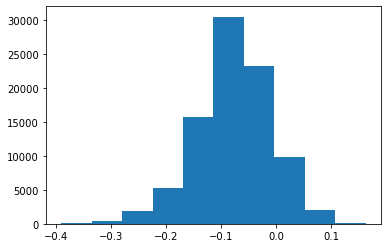

In [44]:
sv_difference = sv_explainer - sv_without_unattended
plt.hist(sv_difference);

In [45]:
print(f"By not including the unattended hospitals in the SHAP values, we are "
      f"missing between {np.exp(sv_difference.min())} and "
      f"{np.exp(sv_difference.max())} fold difference in odds")

By not including the unattended hospitals in the SHAP values, we are missing between 0.6763344986171859 and 1.1762849740812618 fold difference in odds


In [46]:
np.exp(-0.1)

0.9048374180359595

In [47]:
np.exp(sv_difference.mean())

0.9259630628879226

Get set of hosptial names

In [48]:
unique_stroketeams_list = list(set(data["Stroke team"]))

In [49]:
def calc_median_feature_for_patients_attend_hospital(df_values, 
                                                     unique_stroketeams_list, 
                                                     hosp_attend,
                                                     col_names):
    '''
    Create dataframe with hospital along index, column per feature, containing
    median value (for the 5 duifferent values) for each feature for those patients 
    that attend that hospital
    '''
    # initialise list. Will have entry per hosptial.
    # contain median value for each feature for the patients that attend the hosptial
    hosp_median_values = []

    # through each hospital
    for h in unique_stroketeams_list:
    #    calculate median value for the patients that attend hospital for each feature
        mask = hosp_attend == str(h)
        hosp_median_values.append(np.median(df_values[mask],axis=0))

    df_median_value_per_hosp = pd.DataFrame(data=hosp_median_values, 
                                            index=unique_stroketeams_list,
                                            columns=col_names)
    return(df_median_value_per_hosp)

For each values, use function to return the median per set of patients that attend each hospital

In [50]:
df_hosp_median_shap_values_without_unattended_hosp = (
    calc_median_feature_for_patients_attend_hospital(
                              df_hosp_shap_values_without_unattended_hosp,
                              unique_stroketeams_list, 
                              data["Stroke team"],
                              col_names_attendhosp))

In [51]:
df_hosp_median_shap_main = (
    calc_median_feature_for_patients_attend_hospital(
                              df_hosp_shap_main_effects,
                              unique_stroketeams_list, 
                              data["Stroke team"],
                              col_names_attendhosp))

In [52]:
df_hosp_median_shap_interactions_within = (
    calc_median_feature_for_patients_attend_hospital(
                              df_hosp_shap_interactions_within,
                              unique_stroketeams_list, 
                              data["Stroke team"],
                              col_names_attendhosp))

In [53]:
df_hosp_median_shap_interactions_outside = (
    calc_median_feature_for_patients_attend_hospital(
                              df_hosp_shap_interactions_outside,
                              unique_stroketeams_list, 
                              data["Stroke team"],
                              col_names_attendhosp))

In [54]:
df_hosp_median_shap_main_effects_and_within_interactions = (
    calc_median_feature_for_patients_attend_hospital(
                              df_hosp_shap_main_effects_and_within_interactions,
                              unique_stroketeams_list, 
                              data["Stroke team"],
                              col_names_attendhosp))

Add thrombolysis rate to each dataframe

In [55]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [56]:
df_hosp_median_shap_values_without_unattended_hosp = (
        df_hosp_median_shap_values_without_unattended_hosp.join(hosp_ivt_rate))
df_hosp_median_shap_main = (
        df_hosp_median_shap_main.join(hosp_ivt_rate))
df_hosp_median_shap_interactions_within = (
        df_hosp_median_shap_interactions_within.join(hosp_ivt_rate))
df_hosp_median_shap_interactions_outside = (
        df_hosp_median_shap_interactions_outside.join(hosp_ivt_rate))
df_hosp_median_shap_main_effects_and_within_interactions = (
        df_hosp_median_shap_main_effects_and_within_interactions.join(hosp_ivt_rate))

In [57]:
def plot_regressions(df_hosp_median, features, title):
    for feat in features: 
        # Setup data for chart
        x = df_hosp_median[feat]
        y = df_hosp_median['Thrombolysis']

        # Fit a regression line to the x2 points
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(x, y)
        r_square = r_value ** 2
        y_pred = intercept + (x * slope)

        # Create scatter plot with regression line
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)

        ax.scatter(x, y, color = 'k', marker="o", s=20)
        ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

        ax.set_xlabel(f"{title} {feat} "
                      f"(median of the instances that attend the hospital)")
        ax.set_ylabel('Thrombolysis rate')

    #    ax.set_ylim(0, 0.5)
    #    ax.set_xlim(-1.5, 1.5)


        plt.grid()

        # Add  text
        f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
              str("{:.2f}".format(intercept)))
        text = (f'R squared: {r_square:.3f}\np: '
                 f'{p_value:0.4f}\nformula: {f}')

        x_axis_max = ax.get_xlim()[1]
        ax.text(x_axis_max, 0.45, text,
                 bbox=dict(facecolor='white', edgecolor='white'))

        # Save figure

    #    plt.savefig(f'./output/{notebook}_{model_text}'
    #                f'_attended_hosp_shap_value.jpg', 
    #                dpi=300, bbox_inches='tight', pad_inches=0.2)
        plt.show()
    
    return()

### Regression on patient characteristics vs IVT rate

In [58]:
def fit_multiple_regression(df_hosp_median, features):
    X = df_hosp_median[features]
    y = df_hosp_median['Thrombolysis']

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features, columns=["coeff"])
    print(df_reg_coeff)

    # performance
    y_pred = regr.predict(X)

    # Fit a regression line to the obs and pred IVT use
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(y, y_pred)
    r_square = r_value ** 2
    y_pred = intercept + (y * slope)
    print(r_square)

    return()

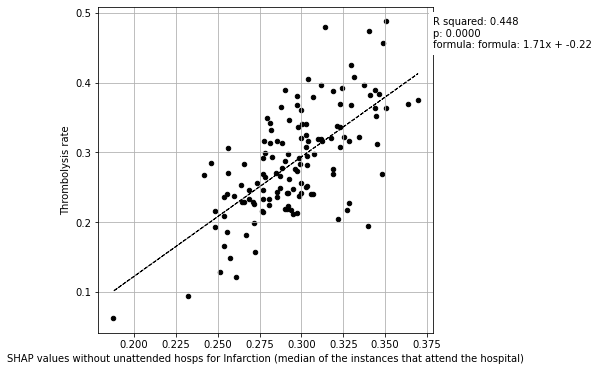

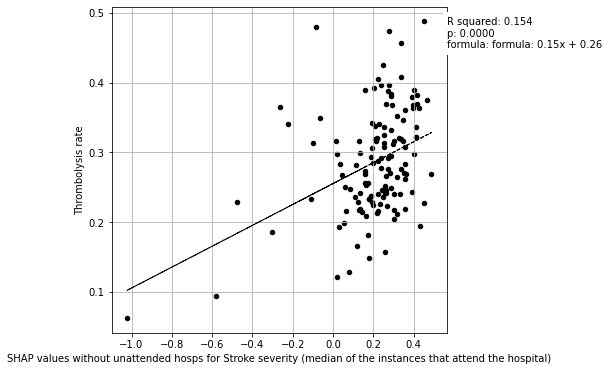

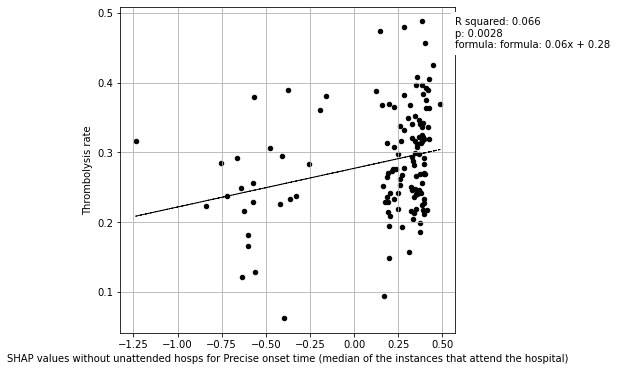

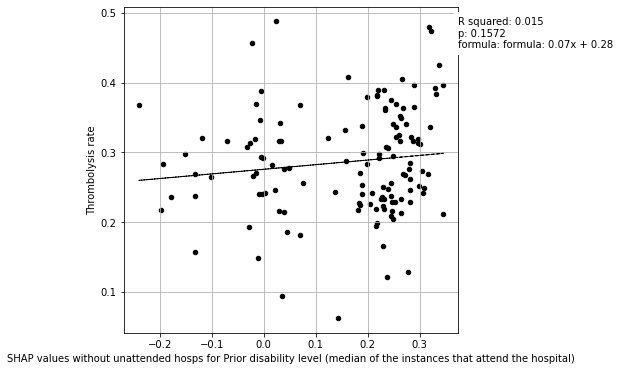

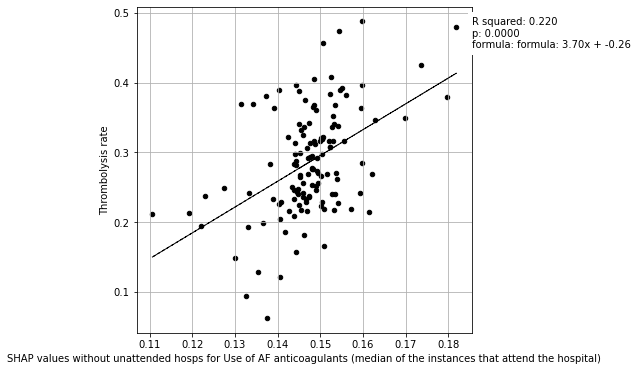

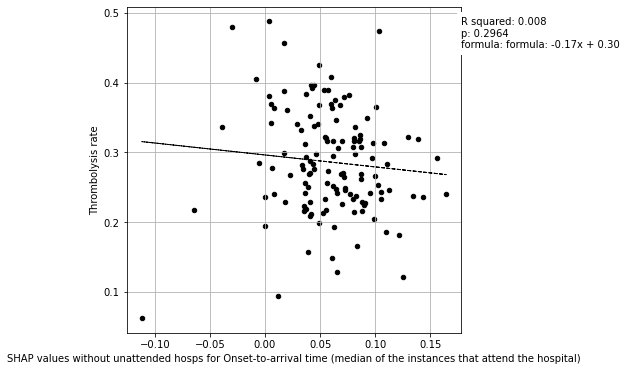

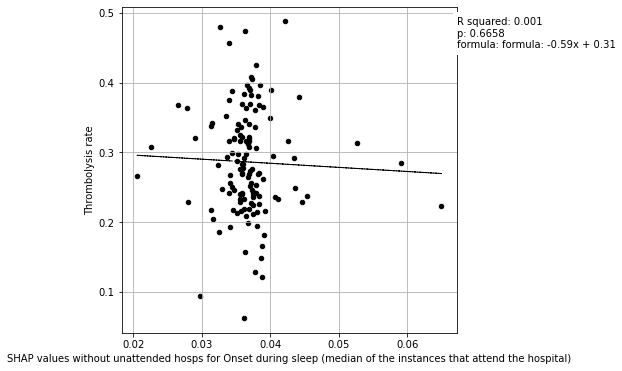

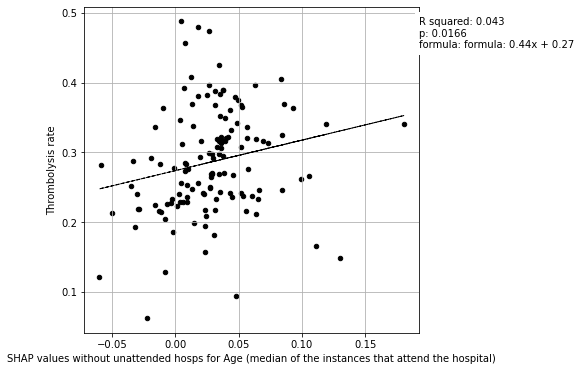

                             coeff
Infarction                1.480199
Stroke severity           0.005347
Precise onset time       -0.003948
Prior disability level   -0.001387
Use of AF anticoagulants  2.484162
Onset-to-arrival time    -0.173104
Onset during sleep        0.671881
Age                       0.289032
0.5707530790365332


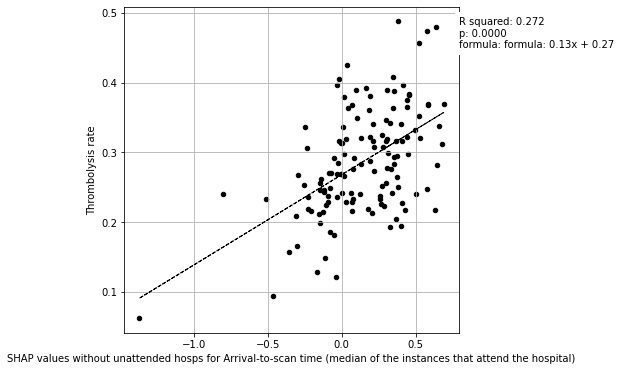

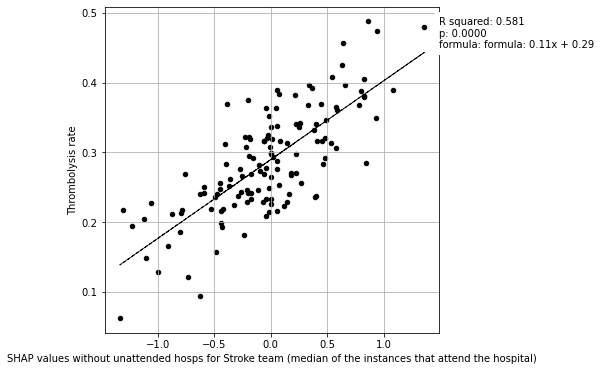

                         coeff
Arrival-to-scan time  0.101459
Stroke team           0.103381
0.7438474472721269


()

In [59]:
title = "SHAP values without unattended hosps for"
df = df_hosp_median_shap_values_without_unattended_hosp

plot_regressions(df, patient_features, title)
fit_multiple_regression(df, patient_features)

plot_regressions(df, hospital_features, title)
fit_multiple_regression(df, hospital_features)

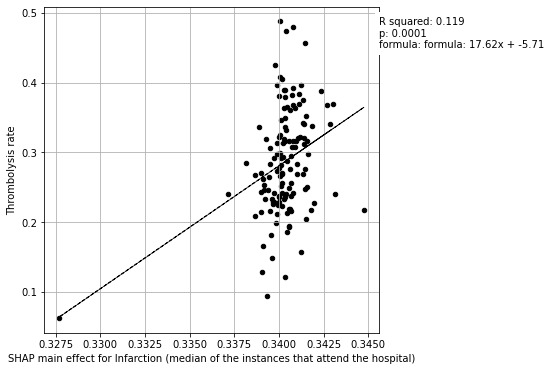

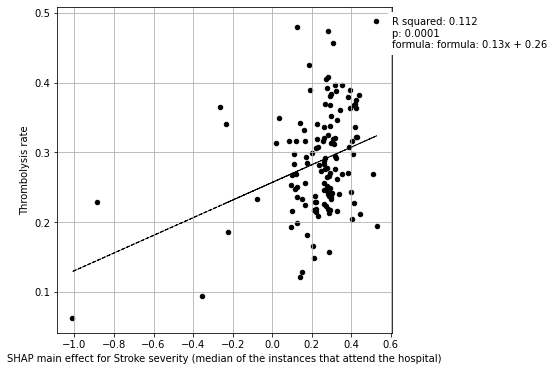

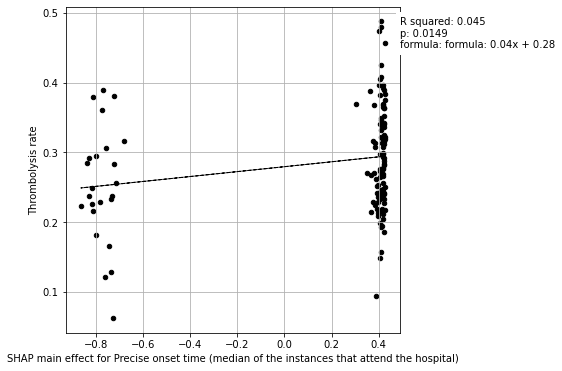

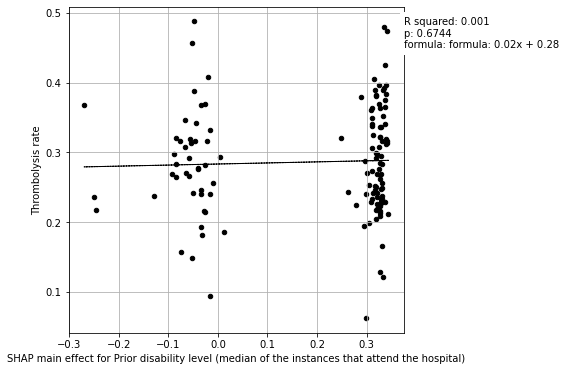

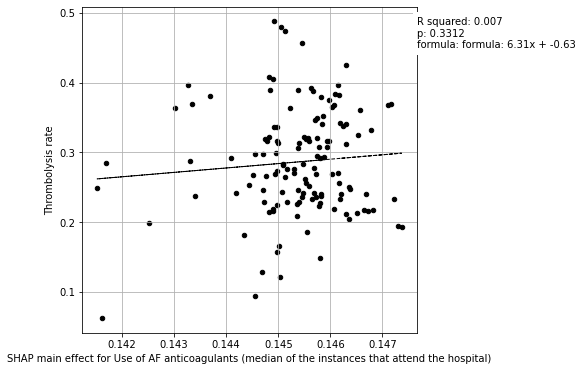

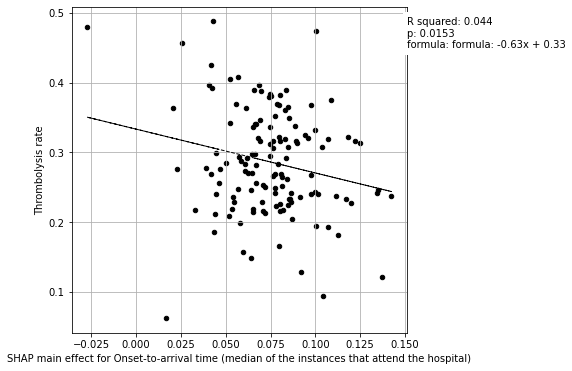

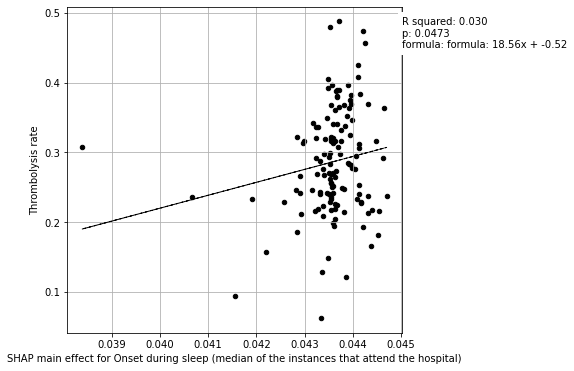

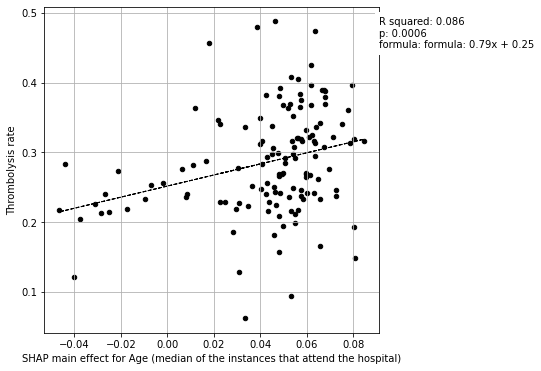

                              coeff
Infarction                12.301399
Stroke severity            0.079947
Precise onset time         0.017648
Prior disability level     0.024381
Use of AF anticoagulants  -3.233718
Onset-to-arrival time     -0.746233
Onset during sleep        18.519396
Age                        0.824363
0.3464893547812586


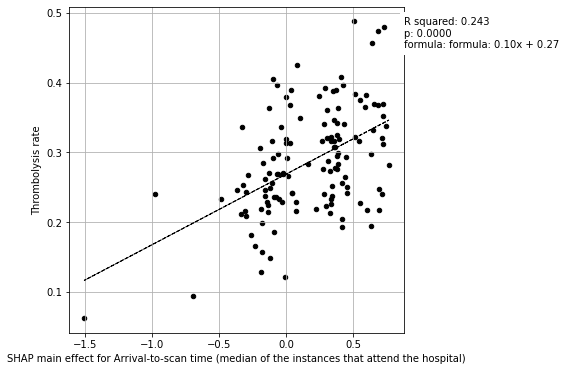

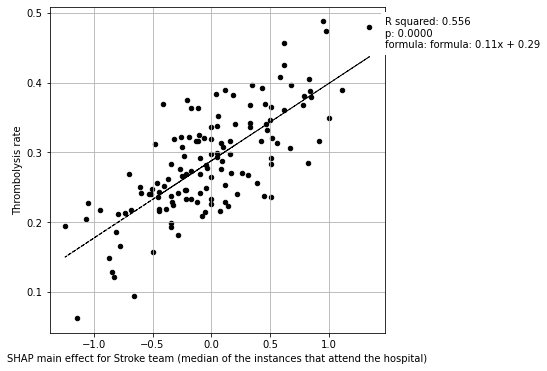

                         coeff
Arrival-to-scan time  0.083892
Stroke team           0.103594
0.7199617091834574


()

In [60]:
title = "SHAP main effect for"
df = df_hosp_median_shap_main

plot_regressions(df, patient_features, title)
fit_multiple_regression(df, patient_features)

plot_regressions(df, hospital_features, title)
fit_multiple_regression(df, hospital_features)

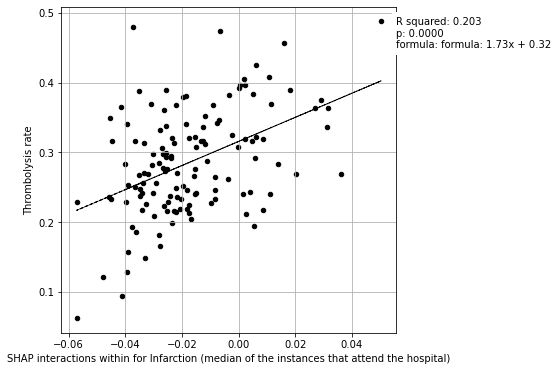

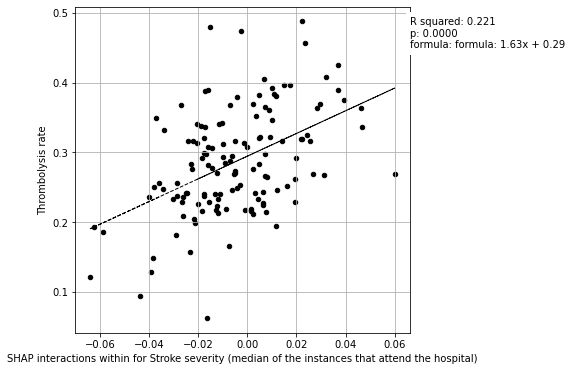

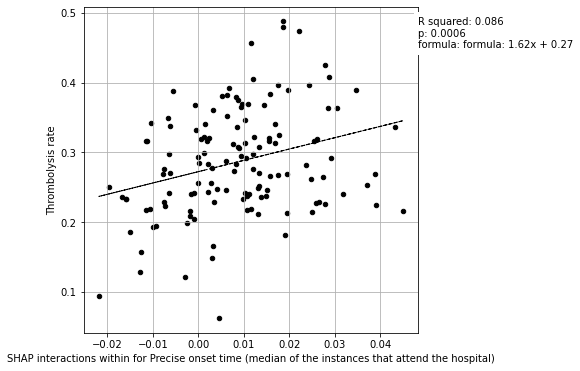

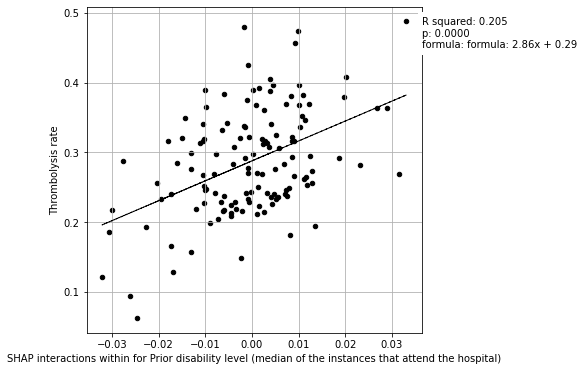

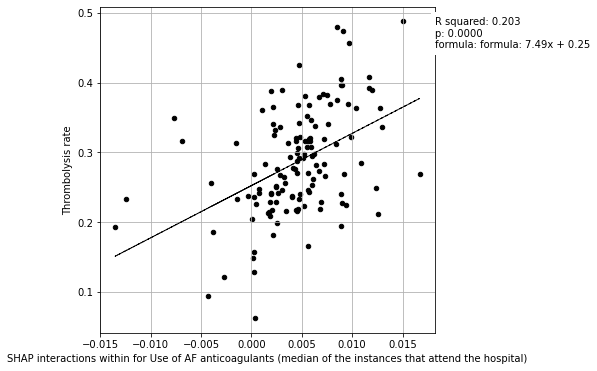

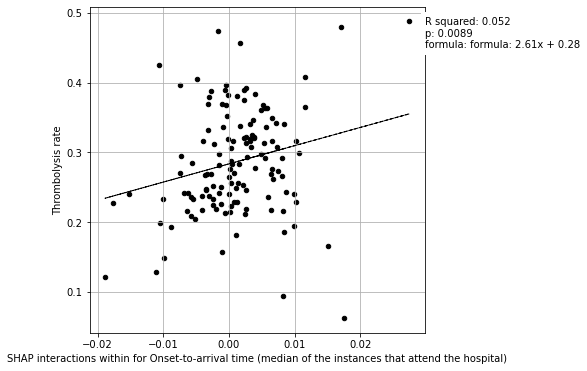

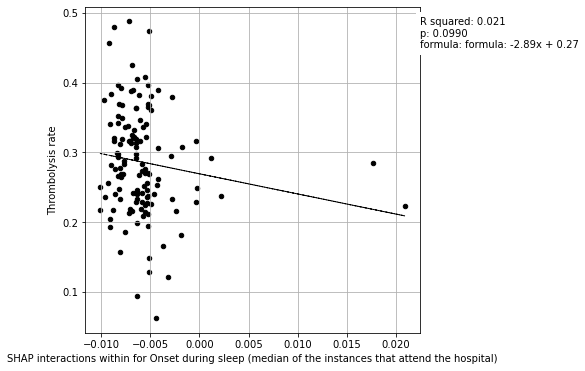

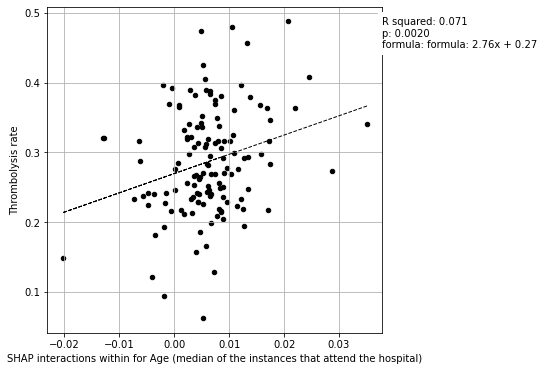

                             coeff
Infarction                0.305420
Stroke severity           0.632199
Precise onset time       -0.271918
Prior disability level    1.415214
Use of AF anticoagulants  2.791496
Onset-to-arrival time     0.702018
Onset during sleep       -2.929034
Age                       0.682573
0.3366913589784877


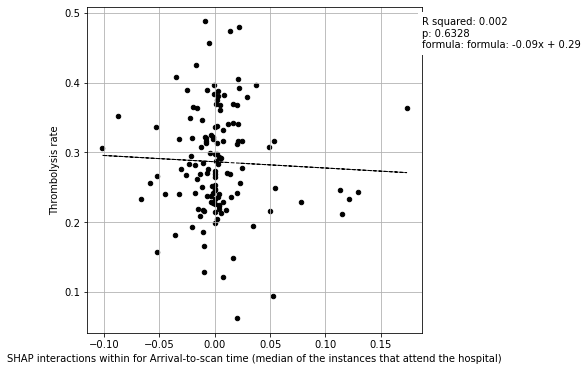

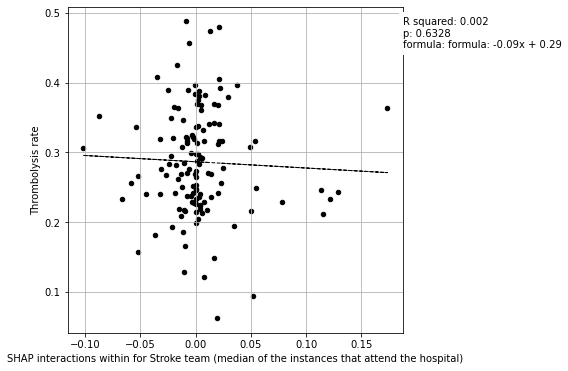

                              coeff
Arrival-to-scan time  131061.686712
Stroke team          -131061.748782
0.009300949719590813


()

In [61]:
title = "SHAP interactions within for"
df = df_hosp_median_shap_interactions_within

plot_regressions(df, patient_features, title)
fit_multiple_regression(df, patient_features)

plot_regressions(df, hospital_features, title)
fit_multiple_regression(df, hospital_features)

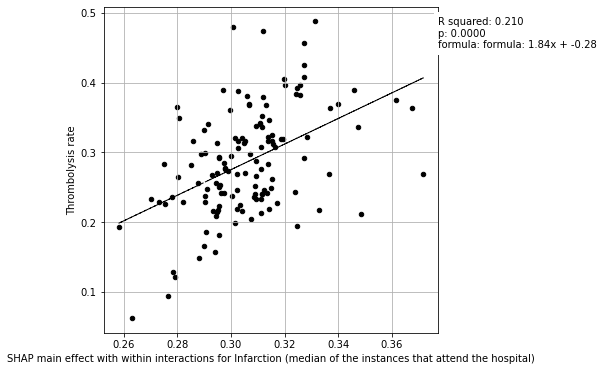

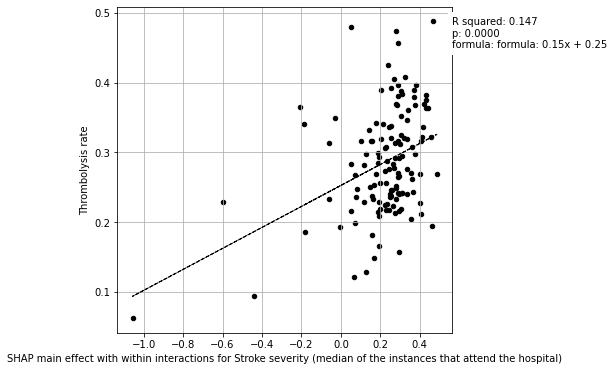

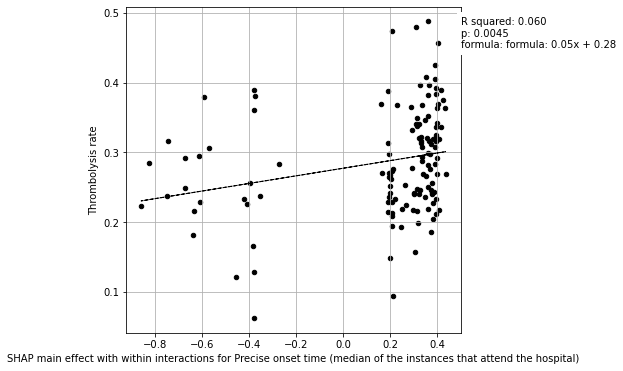

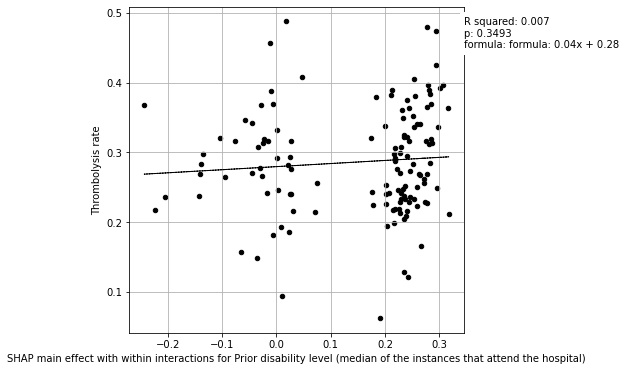

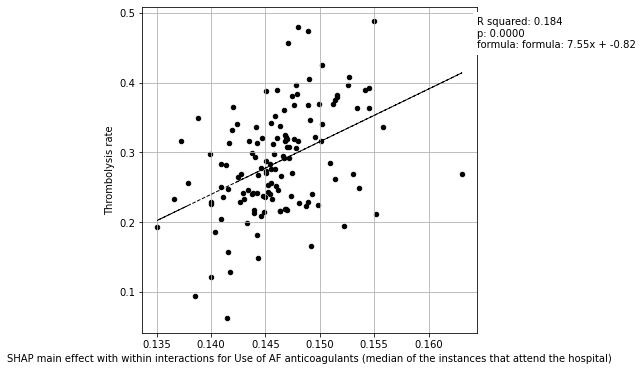

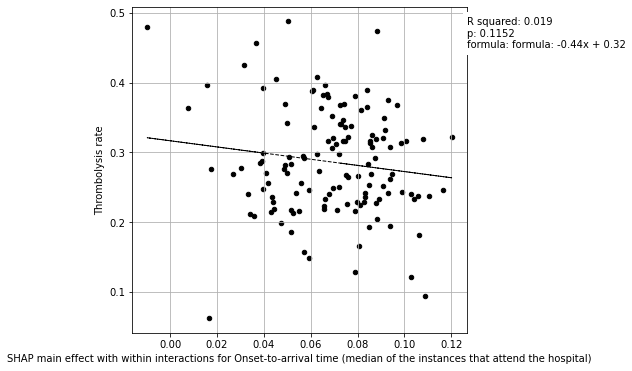

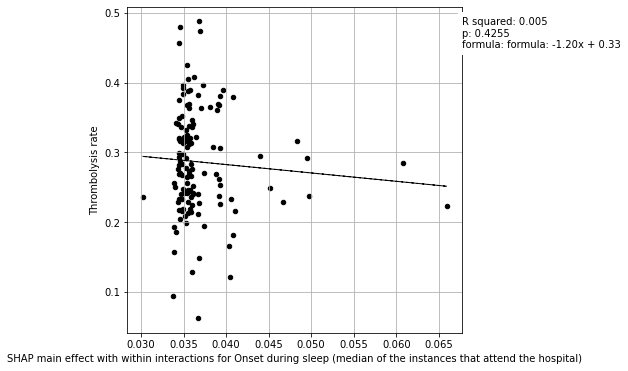

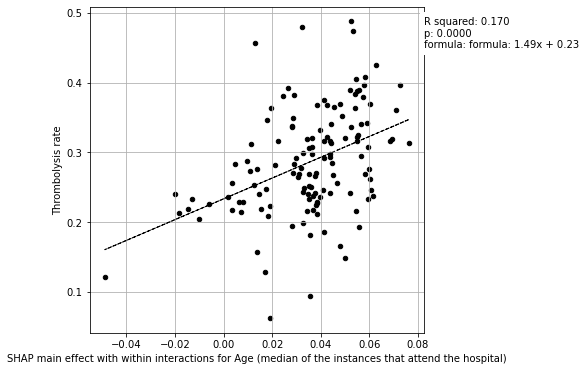

                             coeff
Infarction                0.324343
Stroke severity           0.081963
Precise onset time        0.020054
Prior disability level    0.004908
Use of AF anticoagulants  2.692206
Onset-to-arrival time    -0.385473
Onset during sleep       -0.396007
Age                       1.153297
0.3551012710860802


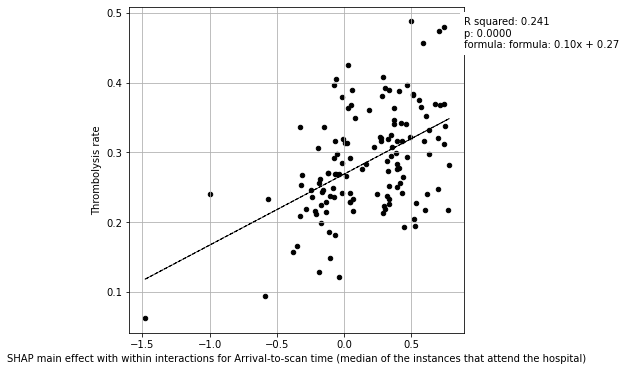

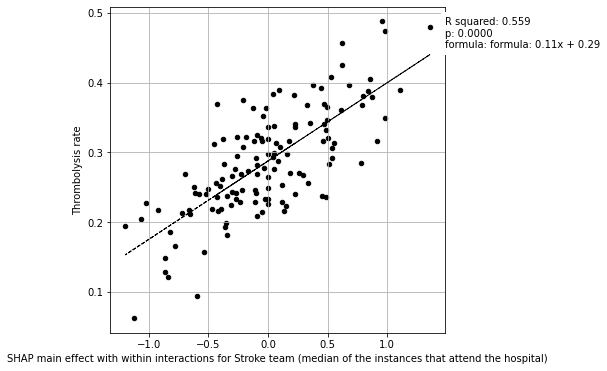

                         coeff
Arrival-to-scan time  0.083962
Stroke team           0.104762
0.7198189535147687


()

In [62]:
title = "SHAP main effect with within interactions for"
df = df_hosp_median_shap_main_effects_and_within_interactions

plot_regressions(df, patient_features, title)
fit_multiple_regression(df, patient_features)

plot_regressions(df, hospital_features, title)
fit_multiple_regression(df, hospital_features)

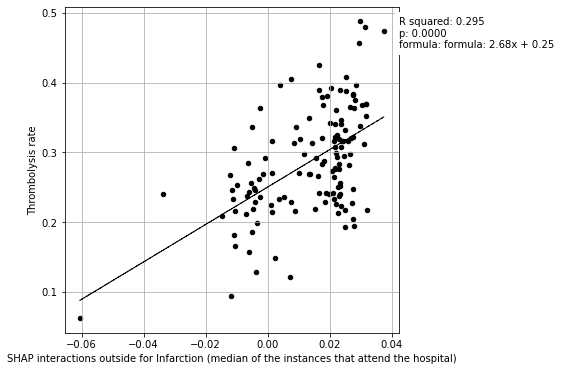

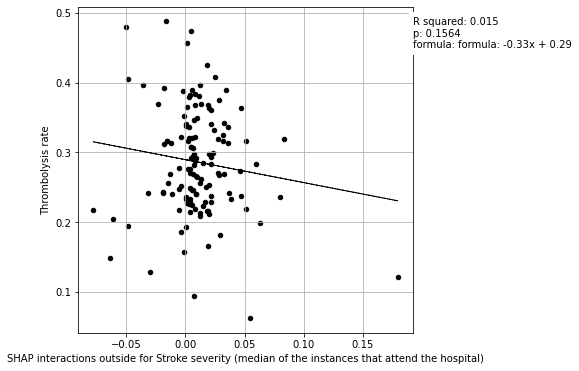

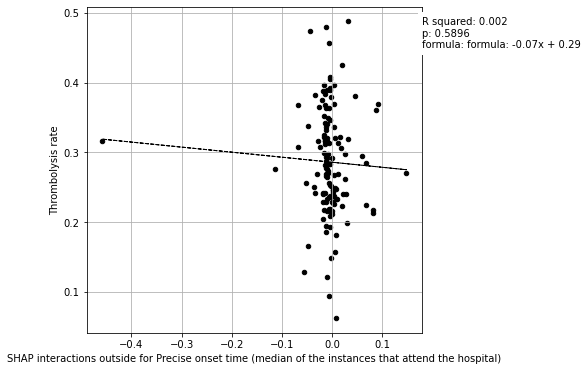

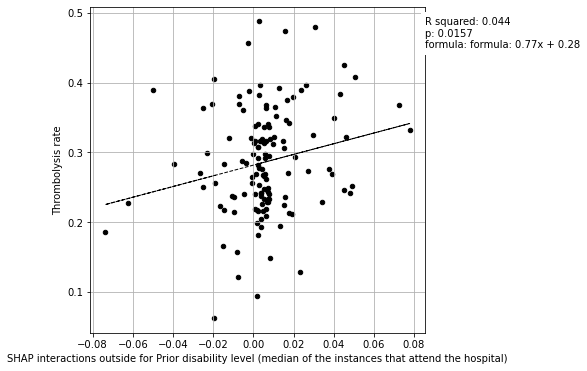

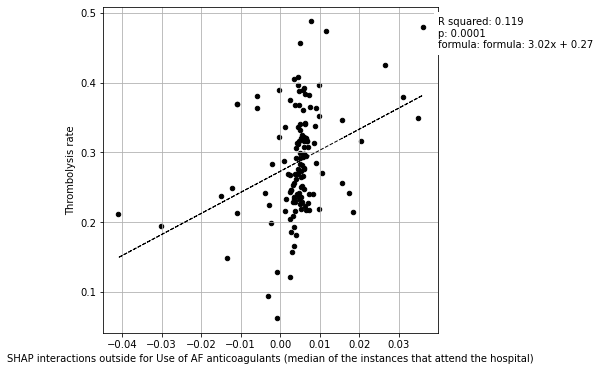

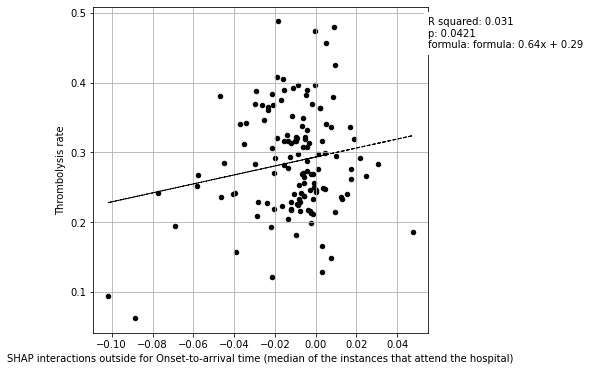

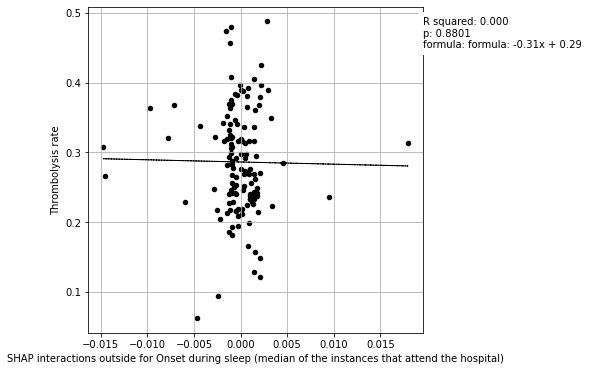

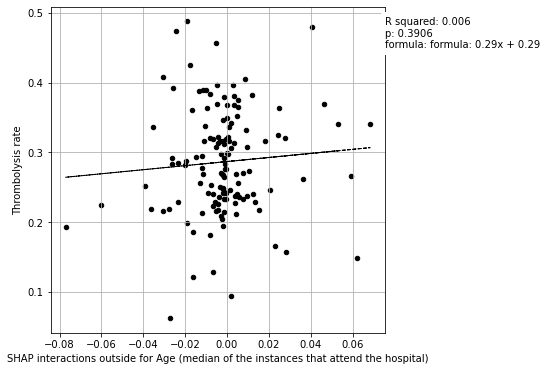

                             coeff
Infarction                2.354357
Stroke severity          -0.039302
Precise onset time        0.080624
Prior disability level    0.475355
Use of AF anticoagulants  1.998818
Onset-to-arrival time     0.405732
Onset during sleep        0.256181
Age                       0.161302
0.387083505822374


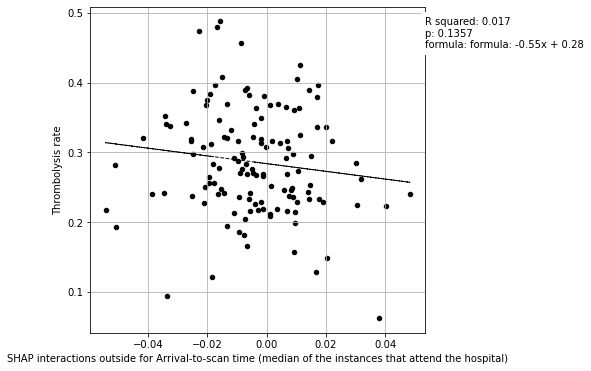

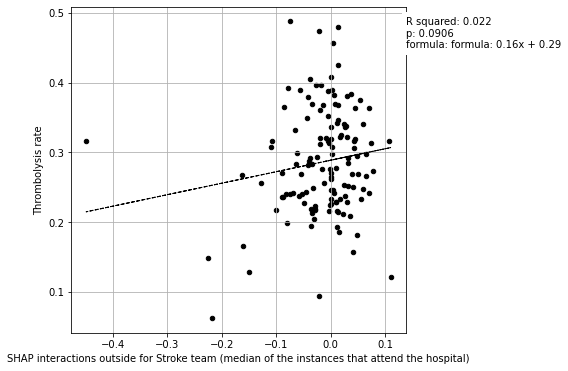

                         coeff
Arrival-to-scan time -0.474419
Stroke team           0.147257
0.03414065167554862


()

In [63]:
title = "SHAP interactions outside for"
df = df_hosp_median_shap_interactions_outside

plot_regressions(df, patient_features, title)
fit_multiple_regression(df, patient_features)

plot_regressions(df, hospital_features, title)
fit_multiple_regression(df, hospital_features)

# Groupings

Task1 

* |p main| + |p interaction|
* |h main + |h interaction|
* |interaction hppph|

For all patients sum absolute (the individual) SHAP values for the above groups.

Sum all the above to give three summed SHAP values groups

Here's the data
* df_hosp_shap_main_effects
* df_hosp_shap_interactions_within
* df_hosp_shap_interactions_outside

not need to use
* df_hosp_shap_values_without_unattended_hosp
* df_hosp_shap_main_effects_and_within_interactions

| main + interaction | is not the same as | main | + | interaction |

Also do above but take p main + | sum (interaction) |

1. Was take the sum of the absulute interactions
2. Take the absolute of the sum of the interaction 

Task2

* |p main| + |sum (p interaction)|
* |h main| + |sum (h interaction)|
* interaction hppph 

For all patients sum absolute (the individual) SHAP values for the above groups.

Sum all the above to give three summed SHAP values groups

Repeat what did for https://samuel-book.github.io/samuel_shap_paper_1/xgb_10_features/12a_xgb_shap_interactions.html here, separating out the histogram into two groups (for Patient and for Hospital)

In [65]:
df_hosp_shap_main_effects

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Stroke team
0,0.676277,0.338386,0.862582,0.430773,0.322120,0.135322,-0.441546,0.042960,0.231744,-0.187852
1,0.447184,0.339734,0.297246,0.434184,0.331810,0.138708,0.165874,0.048222,0.235642,-0.580359
2,-2.979032,0.321163,-1.694299,0.420702,0.379625,0.148083,0.001259,0.039560,0.125615,-1.192582
3,0.336959,-8.517138,0.747195,0.435908,0.358994,0.161105,0.071381,0.043983,0.042129,0.977001
4,0.847006,0.340107,0.851986,0.437559,0.336050,0.143654,0.160698,0.044551,0.053406,0.070702
...,...,...,...,...,...,...,...,...,...,...
88787,0.849938,0.339582,0.712858,0.431210,-0.072783,0.138122,-0.066302,0.044418,0.098550,0.420293
88788,-0.844211,0.318714,-0.850487,-0.808427,-0.715851,0.139013,-0.536557,0.046914,0.207761,0.634106
88789,-0.900821,0.346909,-1.038177,0.426289,-0.099853,0.148487,-0.123910,0.043932,0.055240,-0.482372
88790,0.762628,0.345974,-0.264755,0.427855,0.330211,0.141918,0.138462,0.046009,0.090013,-0.311936


Get data for the three groups. All as individual absolute values

Lookig at magnitude of contribution from each element (be it main effect or interaction).

In [66]:
# for patient features
total_of_abs_p_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[patient_features]).sum(axis=(1)))
total_of_abs_p_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[patient_features]).sum(axis=(1)))
# sum patient contributions
total_of_abs_p_contributions_per_instance = (total_of_abs_p_main_per_instance + 
                                total_of_abs_p_interaction_per_instance)

# proportion of patient contributions from interactions
total_of_abs_p_interactions_proportion_per_instance = (
        total_of_abs_p_interaction_per_instance/total_of_abs_p_contributions_per_instance)

# for patient features
total_of_abs_h_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[hospital_features]).sum(axis=(1)))
total_of_abs_h_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[hospital_features]).sum(axis=(1)))
# sum hosptial contributions
total_of_abs_h_contributions_per_instance = (total_of_abs_h_main_per_instance + 
                                total_of_abs_h_interaction_per_instance)
# proportion of hospital contributions from interactions
total_of_abs_h_interactions_proportion_per_instance = (
                                total_of_abs_h_interaction_per_instance/
                                total_of_abs_h_contributions_per_instance)

# for hospital-patient features
total_of_abs_hpph_contributions_per_instance = (
                        np.abs(df_hosp_shap_interactions_outside).sum(axis=(1)))

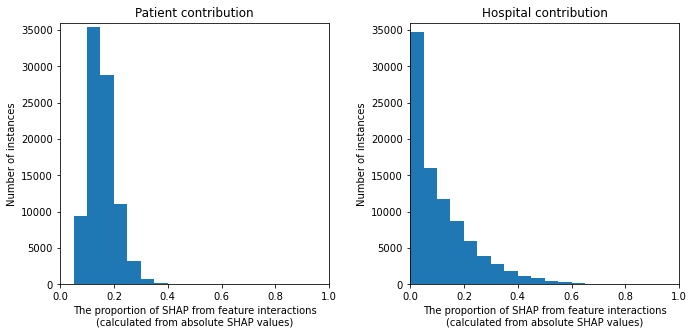

In [67]:
# plot the proportion from interactions as histogram
bins = np.arange(0,1,0.05)

fig = plt.figure(figsize=(10,5))

# Plot patient contribution
ax1 = fig.add_subplot(121)
ax1.hist(total_of_abs_p_interactions_proportion_per_instance, bins=bins);
ax1.set_title("Patient contribution")
ax1.set_xlabel("The proportion of SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax1.set_ylabel("Number of instances")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 36000)

# Plot hospital contribution
ax2 = fig.add_subplot(122)
ax2.hist(total_of_abs_h_interactions_proportion_per_instance, bins=bins);
ax2.set_title("Hospital contribution")
ax2.set_xlabel("The proportion of SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax2.set_ylabel("Number of instances")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 36000)

plt.tight_layout(pad=2)

plt.show()

For hosptial contributions, the 1 stands for all from interactions, and 0 from main effect. So for majority of patients all hosptial contributions comes from main effect (either hosptial attended, or arrival to scan).

Main effect also dominant for the patient contribution, but to a lesser extent than seen for the hosptial contribution.

In [68]:
print (f"Sum of absolute contributions from patient features: "
       f"{round(total_of_abs_p_contributions_per_instance.sum(),0)}")
print (f"Sum of absolute contributions from hospital features: "
       f"{round(total_of_abs_h_contributions_per_instance.sum(),0)}")
print (f"Sum of absolute contributions from patient-hospital interactions: "
       f"{round(total_of_abs_hpph_contributions_per_instance.sum(),0)}")
print("Sum of the individual absolute log odds")

Sum of absolute contributions from patient features: 444218.0
Sum of absolute contributions from hospital features: 139988.0
Sum of absolute contributions from patient-hospital interactions: 88098.0
Sum of the individual absolute log odds


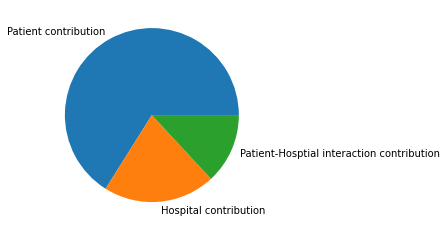

In [69]:
y = np.array([total_of_abs_p_contributions_per_instance.sum(), 
              total_of_abs_h_contributions_per_instance.sum(), 
              total_of_abs_hpph_contributions_per_instance.sum()])
mylabels = ["Patient contribution", "Hospital contribution", 
            "Patient-Hosptial interaction contribution"]
plt.pie(y, labels = mylabels);

Get data for the three groups. All as absolute values of the raw sum.

In [70]:
# for patient features
abs_of_total_p_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[patient_features].sum(axis=(1))))
abs_of_total_p_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[patient_features].sum(axis=(1))))
# sum patient contributions
abs_of_total_p_contributions_per_instance = (abs_of_total_p_main_per_instance + 
                                abs_of_total_p_interaction_per_instance)

# proportion of patient contributions from interactions
abs_of_total_p_interactions_proportion_per_instance = (
                abs_of_total_p_interaction_per_instance/
                abs_of_total_p_contributions_per_instance)

# for patient features
abs_of_total_h_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[hospital_features].sum(axis=(1))))
abs_of_total_h_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[hospital_features].sum(axis=(1))))
# sum hosptial contributions
abs_of_total_h_contributions_per_instance = (abs_of_total_h_main_per_instance + 
                                abs_of_total_h_interaction_per_instance)
# proportion of hospital contributions from interactions
abs_of_total_h_interactions_proportion_per_instance = (
                                abs_of_total_h_interaction_per_instance/
                                abs_of_total_h_contributions_per_instance)

# for hospital-patient features
abs_of_total_hpph_contributions_per_instance = (
                        np.abs(df_hosp_shap_interactions_outside.sum(axis=(1))))

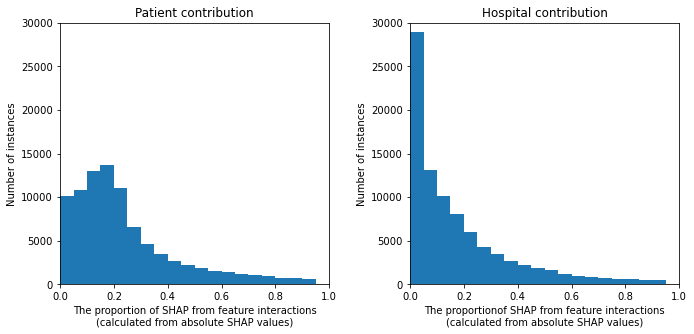

In [71]:
# plot the proportion from interactions as histogram
bins = np.arange(0,1,0.05)
fig = plt.figure(figsize=(10,5))

# Plot patient contribution
ax1 = fig.add_subplot(121)
ax1.hist(abs_of_total_p_interactions_proportion_per_instance, bins=bins);
ax1.set_title("Patient contribution")
ax1.set_xlabel("The proportion of SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax1.set_ylabel("Number of instances")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 30000)

# Plot hospital contribution
ax2 = fig.add_subplot(122)
ax2.hist(abs_of_total_h_interactions_proportion_per_instance, bins=bins);
ax2.set_title("Hospital contribution")
ax2.set_xlabel("The proportionof SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax2.set_ylabel("Number of instances")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 30000)

plt.tight_layout(pad=2)

plt.show()

In [72]:
print (f"Absolute of sum of contributions from patient features: "
       f"{round(abs_of_total_p_contributions_per_instance.sum(),0)}")
print (f"Absolute of sum of contributions from hospital features: "
       f"{round(abs_of_total_h_contributions_per_instance.sum(),0)}")
print (f"Absolute of sum of contributions from patient-hospital interactions: "
       f"{round(abs_of_total_hpph_contributions_per_instance.sum(),0)}")

Absolute of sum of contributions from patient features: 263261.0
Absolute of sum of contributions from hospital features: 114377.0
Absolute of sum of contributions from patient-hospital interactions: 54049.0


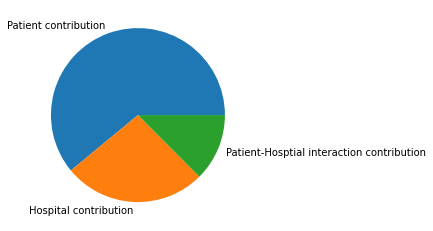

In [73]:
y = np.array([abs_of_total_p_contributions_per_instance.sum(), 
              abs_of_total_h_contributions_per_instance.sum(), 
              abs_of_total_hpph_contributions_per_instance.sum()])
mylabels = ["Patient contribution", "Hospital contribution", 
            "Patient-Hosptial interaction contribution"]
plt.pie(y, labels = mylabels);

Each patient, the SHAP that comes from h_contribution, and p_contribution.

Table of patient SHAP.

Then table with three columns: sum P contributions, sum h contributions, sum hpph contribution.

No absolute.

Save file.

Share with MA, to then check if correlated with embedding-NN output.

In [101]:
# for patient features
total_p_main_per_instance = (
            df_hosp_shap_main_effects[patient_features].sum(axis=(1)))
total_p_interaction_per_instance = (
            df_hosp_shap_interactions_within[patient_features].sum(axis=(1)))
# sum patient contributions
total_p_contributions_per_instance = (total_p_main_per_instance + 
                                      total_p_interaction_per_instance)

# proportion of patient contributions from interactions
total_p_interactions_proportion_per_instance = (
        total_p_interaction_per_instance/total_p_contributions_per_instance)

# for patient features
total_h_main_per_instance = (
            df_hosp_shap_main_effects[hospital_features].sum(axis=(1)))
total_h_interaction_per_instance = (
            df_hosp_shap_interactions_within[hospital_features]).sum(axis=(1))
# sum hosptial contributions
total_h_contributions_per_instance = (total_h_main_per_instance + 
                                      total_h_interaction_per_instance)
# proportion of hospital contributions from interactions
total_h_interactions_proportion_per_instance = (
        total_h_interaction_per_instance/total_h_contributions_per_instance)

# for hospital-patient features
total_hpph_contributions_per_instance = (
                            df_hosp_shap_interactions_outside.sum(axis=(1)))

total_shap_value_per_instance = shap_values_extended.values.sum(axis=(1))
total_unattended_h_per_instance = (total_shap_value_per_instance - 
                                   (total_p_contributions_per_instance +
                                    total_h_contributions_per_instance +
                                    total_hpph_contributions_per_instance))


In [102]:
columns = ["sum_p_contributions", "sum_h_contributions",
           "sum_hpph_contributions", "sum_h_unattended_contributions",
           "total_shap_value"]

df_shap = np.vstack((total_p_contributions_per_instance, 
                     total_h_contributions_per_instance, 
                     total_hpph_contributions_per_instance,
                     total_unattended_h_per_instance,
                     total_shap_value_per_instance,
                     )).T

df_to_file = pd.DataFrame(data=df_shap, 
                          columns=columns)

df_to_file.to_csv(f'./output/{notebook}_{model_text}'
                  f'_shap_p_h_hpph_contributions.csv', )